In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from process import Tileset

def show(img, plt=plt):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))

%matplotlib inline

In [2]:
PATH = "dist/modernexteriors-win/Modern_Exteriors_16x16/ME_Theme_Sorter_16x16"
path_a = f"{PATH}/8_Worksite_Singles_16x16/ME_Singles_Worksite_16x16_Stacked_Material_4.png"
path_b = f"{PATH}/8_Worksite_16x16.png"
y, x = 208, 96

In [3]:
PATH = "dist/modernexteriors-win/Modern_Exteriors_16x16/ME_Theme_Sorter_16x16"
path_a = f"{PATH}/3_City_Props_Singles_16x16/ME_Singles_City_Props_16x16_Tree_13.png"
path_b = f"{PATH}/3_City_Props_16x16.png"
y, x = 472, 386

In [4]:
PATH = "dist/modernexteriors-win/Modern_Exteriors_16x16/ME_Theme_Sorter_16x16"
path_a = f"{PATH}/7_Villas_Singles_16x16/ME_Singles_Villas_16x16_Villa_Yard_Flowers_9.png"
path_b = f"{PATH}/7_Villas_16x16.png"
y, x = 544, 352

In [5]:
PATH = "dist/modernexteriors-win/Modern_Exteriors_16x16/ME_Theme_Sorter_16x16"
path_a = f"{PATH}/7_Villas_Singles_16x16/ME_Singles_Villas_16x16_Tree_House_1.png"
path_b = f"{PATH}/7_Villas_16x16.png"
y, x = 736, 128

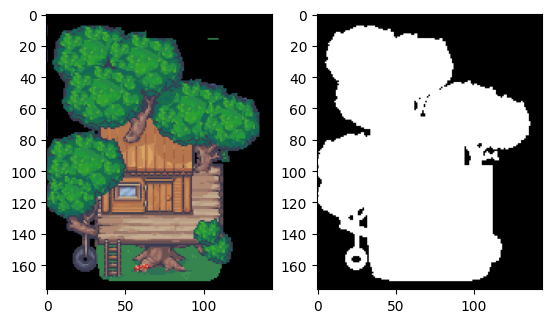

In [6]:
a = cv2.imread(path_a, cv2.IMREAD_UNCHANGED)
fig, axes = plt.subplots(1, 2)
show(a[:,:,:3], axes[0])
show(a[:,:,3], axes[1])

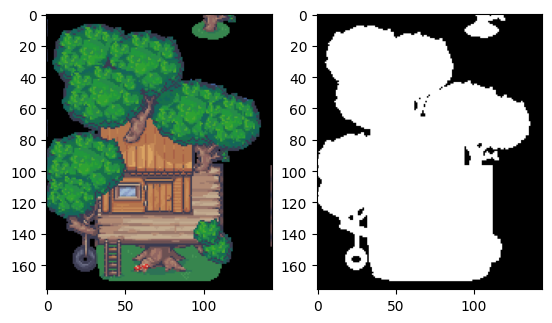

In [7]:
h, w = a.shape[:2]
b = cv2.imread(path_b, cv2.IMREAD_UNCHANGED)[y:y+h,x:x+w]
fig, axes = plt.subplots(1, 2)
show(b[:,:,:3], axes[0])
show(b[:,:,3], axes[1])

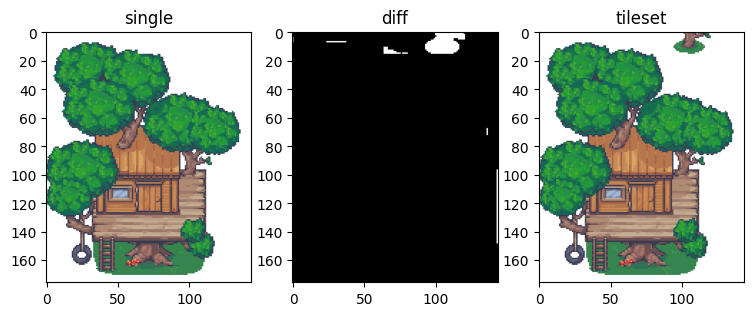

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].set_title("single")
axes[1].set_title("diff")
axes[2].set_title("tileset")
show(a, axes[0])
diff = (a != b).max(axis=2).astype(np.uint8) * 255
show(diff, axes[1])
show(b, axes[2])
plt.show()

In [9]:
a_score = Tileset._compute_score(a, b)
b_score = Tileset._compute_score(b, a)
a_score, b_score

(1.0, 0.9829283887468031)